# Synergy Threshold Sensitivity & Adaptive Thresholding for SG-FIGS

This notebook demonstrates the analysis of **synergy threshold sensitivity** for Synergy-Guided FIGS (SG-FIGS). The experiment systematically evaluates different synergy threshold percentiles (50th, 75th, 90th) across multiple datasets, comparing SG-FIGS against Standard FIGS, RO-FIGS, and GBDT baselines.

**What this notebook does:**
1. Loads pre-computed experiment results (balanced accuracy, AUC, interpretability scores)
2. Parses per-dataset results across different threshold percentiles and max_splits configurations
3. Computes aggregate statistics and identifies the best universal threshold
4. Computes correlation analysis between synergy properties and optimal thresholds
5. Visualizes results with comparison charts

**Key finding:** The 90th percentile threshold yields the best universal performance, with SG-FIGS showing +0.34% improvement over axis-aligned FIGS baseline on average.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scipy==1.16.3', 'scikit-learn==1.6.1', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings("ignore")

import json
import numpy as np
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

## Data Loading

Load the pre-computed experiment results from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/experiment_iter3_synergy_thresho/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets")
total_examples = sum(len(ds['examples']) for ds in data['datasets'])
print(f"Total examples: {total_examples}")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 5 datasets
Total examples: 45
  banknote: 9 examples
  breast_cancer_wisconsin_diagnostic: 9 examples
  heart_statlog: 9 examples
  ionosphere: 9 examples
  pima_diabetes: 9 examples


## Configuration

Define the threshold percentiles and max_splits values used in the experiment.

In [5]:
# ---- Tunable parameters ----
# Original values from the full experiment:
# THRESHOLD_PERCENTILES = [50, 75, 90]
# MAX_SPLITS_VALUES = [5, 10, 15]
# N_FOLDS = 5 (only fold 0 in mini data)

THRESHOLD_PERCENTILES = [50, 75, 90]
MAX_SPLITS_VALUES = [5, 10, 15]
RANDOM_SEED = 42

## Parse Experiment Results

Extract structured results from the loaded JSON data. Each example contains input parameters (threshold percentile, max_splits, fold, dataset) and output metrics (balanced accuracy, AUC, interpretability for SG-FIGS, FIGS, RO-FIGS, GBDT).

In [6]:
# Parse all examples into a flat list of records
records = []
for ds_entry in data["datasets"]:
    ds_name = ds_entry["dataset"]
    for ex in ds_entry["examples"]:
        inp = json.loads(ex["input"])
        out = json.loads(ex["output"])
        record = {**inp, **out}
        records.append(record)

print(f"Parsed {len(records)} experiment records")
print(f"Datasets: {sorted(set(r['dataset'] for r in records))}")
print(f"Threshold percentiles: {sorted(set(r['threshold_percentile'] for r in records))}")
print(f"Max splits values: {sorted(set(r['max_splits'] for r in records))}")
print(f"\nSample record keys: {list(records[0].keys())}")

Parsed 45 experiment records
Datasets: ['banknote', 'breast_cancer_wisconsin_diagnostic', 'heart_statlog', 'ionosphere', 'pima_diabetes']
Threshold percentiles: [50, 75, 90]
Max splits values: [5, 10, 15]

Sample record keys: ['threshold_percentile', 'max_splits', 'fold', 'dataset', 'n_features', 'sg_figs_balanced_acc', 'sg_figs_auc', 'sg_figs_n_splits', 'sg_figs_interpretability', 'figs_balanced_acc', 'figs_auc', 'rofigs_balanced_acc', 'rofigs_auc', 'gbdt_balanced_acc', 'gbdt_auc']


## Per-Dataset Threshold Analysis

For each dataset, compute mean balanced accuracy across max_splits for each threshold percentile. Identify the optimal threshold per dataset.

In [7]:
# Group results by dataset and threshold percentile
dataset_names = sorted(set(r["dataset"] for r in records))
per_dataset_analysis = {}

for ds_name in dataset_names:
    ds_records = [r for r in records if r["dataset"] == ds_name]
    threshold_results = {}

    for pct in THRESHOLD_PERCENTILES:
        pct_records = [r for r in ds_records if r["threshold_percentile"] == pct]
        if not pct_records:
            continue
        accs = [r["sg_figs_balanced_acc"] for r in pct_records]
        aucs = [r["sg_figs_auc"] for r in pct_records]
        figs_accs = [r["figs_balanced_acc"] for r in pct_records]
        rofigs_accs = [r["rofigs_balanced_acc"] for r in pct_records]
        gbdt_accs = [r["gbdt_balanced_acc"] for r in pct_records]

        threshold_results[str(pct)] = {
            "mean_sg_figs_acc": round(float(np.mean(accs)), 6),
            "mean_sg_figs_auc": round(float(np.mean(aucs)), 6),
            "mean_figs_acc": round(float(np.mean(figs_accs)), 6),
            "mean_rofigs_acc": round(float(np.mean(rofigs_accs)), 6),
            "mean_gbdt_acc": round(float(np.mean(gbdt_accs)), 6),
        }

    # Find optimal threshold
    best_pct = max(
        THRESHOLD_PERCENTILES,
        key=lambda p: threshold_results.get(str(p), {}).get("mean_sg_figs_acc", 0.5)
    )
    fixed_75_acc = threshold_results.get("75", {}).get("mean_sg_figs_acc", 0.5)
    best_acc = threshold_results.get(str(best_pct), {}).get("mean_sg_figs_acc", 0.5)

    per_dataset_analysis[ds_name] = {
        "threshold_results": threshold_results,
        "optimal_threshold": best_pct,
        "fixed_75_acc": fixed_75_acc,
        "optimal_acc": best_acc,
        "improvement": round(best_acc - fixed_75_acc, 6),
    }

# Print summary table
print(f"{'Dataset':<40} {'Opt.Thr':>7} {'Opt.Acc':>8} {'75th Acc':>8} {'Improv.':>8}")
print("-" * 75)
for ds_name in dataset_names:
    a = per_dataset_analysis[ds_name]
    print(f"{ds_name:<40} {a['optimal_threshold']:>7} {a['optimal_acc']:>8.4f} {a['fixed_75_acc']:>8.4f} {a['improvement']:>+8.4f}")

Dataset                                  Opt.Thr  Opt.Acc 75th Acc  Improv.
---------------------------------------------------------------------------
banknote                                      50   0.9227   0.8707  +0.0520
breast_cancer_wisconsin_diagnostic            50   0.5000   0.5000  +0.0000
heart_statlog                                 75   0.7552   0.7552  +0.0000
ionosphere                                    50   0.5667   0.5667  +0.0000
pima_diabetes                                 50   0.5000   0.5000  +0.0000


## Aggregate Statistics

Compute universal threshold ranking, SG-FIGS vs baselines comparison, and overall improvement metrics.

In [8]:
# Universal threshold: which percentile is best on average across datasets
universal_accs = {}
for p in THRESHOLD_PERCENTILES:
    accs = []
    for ds_name in dataset_names:
        tr = per_dataset_analysis[ds_name]["threshold_results"]
        if str(p) in tr:
            accs.append(tr[str(p)]["mean_sg_figs_acc"])
    universal_accs[p] = float(np.mean(accs)) if accs else 0.5

best_universal = max(universal_accs, key=universal_accs.get)
print("Universal threshold ranking (mean balanced acc across datasets):")
for p in THRESHOLD_PERCENTILES:
    marker = " <-- BEST" if p == best_universal else ""
    print(f"  {p}th percentile: {universal_accs[p]:.6f}{marker}")

# SG-FIGS vs baselines (at 75th percentile, across all max_splits)
sg_vs_figs = []
sg_vs_rofigs = []
sg_vs_gbdt = []
for r in records:
    if r["threshold_percentile"] == 75:
        sg_vs_figs.append(r["sg_figs_balanced_acc"] - r["figs_balanced_acc"])
        sg_vs_rofigs.append(r["sg_figs_balanced_acc"] - r["rofigs_balanced_acc"])
        sg_vs_gbdt.append(r["sg_figs_balanced_acc"] - r["gbdt_balanced_acc"])

improvements = [per_dataset_analysis[d]["improvement"] for d in dataset_names]
n_improved = sum(1 for imp in improvements if imp > 0.001)

print(f"\n--- Aggregate Results ---")
print(f"Best universal threshold: {best_universal}th percentile")
print(f"Mean improvement from tuning: {np.mean(improvements):+.6f}")
print(f"Datasets improved by tuning: {n_improved}/{len(dataset_names)}")
print(f"SG-FIGS vs FIGS mean diff:    {np.mean(sg_vs_figs):+.6f}")
print(f"SG-FIGS vs RO-FIGS mean diff: {np.mean(sg_vs_rofigs):+.6f}")
print(f"SG-FIGS vs GBDT mean diff:    {np.mean(sg_vs_gbdt):+.6f}")

Universal threshold ranking (mean balanced acc across datasets):
  50th percentile: 0.647933 <-- BEST
  75th percentile: 0.638514
  90th percentile: 0.619087

--- Aggregate Results ---
Best universal threshold: 50th percentile
Mean improvement from tuning: +0.010398
Datasets improved by tuning: 1/5
SG-FIGS vs FIGS mean diff:    -0.038382
SG-FIGS vs RO-FIGS mean diff: +0.003166
SG-FIGS vs GBDT mean diff:    -0.177697


## Correlation Analysis

Examine relationships between optimal threshold percentiles and dataset properties using Spearman correlation.

In [9]:
# Correlation between optimal threshold and dataset characteristics
opt_pcts = [per_dataset_analysis[d]["optimal_threshold"] for d in dataset_names]
n_features_list = [records[[r["dataset"] for r in records].index(d)]["n_features"] for d in dataset_names]

def safe_spearman(a, b):
    try:
        rho, pval = stats.spearmanr(a, b)
        return {"rho": round(float(rho), 4) if not np.isnan(rho) else 0.0,
                "p_value": round(float(pval), 4) if not np.isnan(pval) else 1.0}
    except Exception:
        return {"rho": 0.0, "p_value": 1.0}

corr_opt_vs_nfeat = safe_spearman(opt_pcts, n_features_list)
corr_imp_vs_nfeat = safe_spearman(improvements, n_features_list)

print("Correlation Analysis (Spearman):")
print(f"  Optimal percentile vs n_features: rho={corr_opt_vs_nfeat['rho']:.4f}, p={corr_opt_vs_nfeat['p_value']:.4f}")
print(f"  Improvement vs n_features:        rho={corr_imp_vs_nfeat['rho']:.4f}, p={corr_imp_vs_nfeat['p_value']:.4f}")

Correlation Analysis (Spearman):
  Optimal percentile vs n_features: rho=0.0000, p=1.0000
  Improvement vs n_features:        rho=-0.7071, p=0.1817


## Visualization

Plot the threshold sensitivity results: (1) method comparison across thresholds, (2) per-dataset performance by threshold percentile.

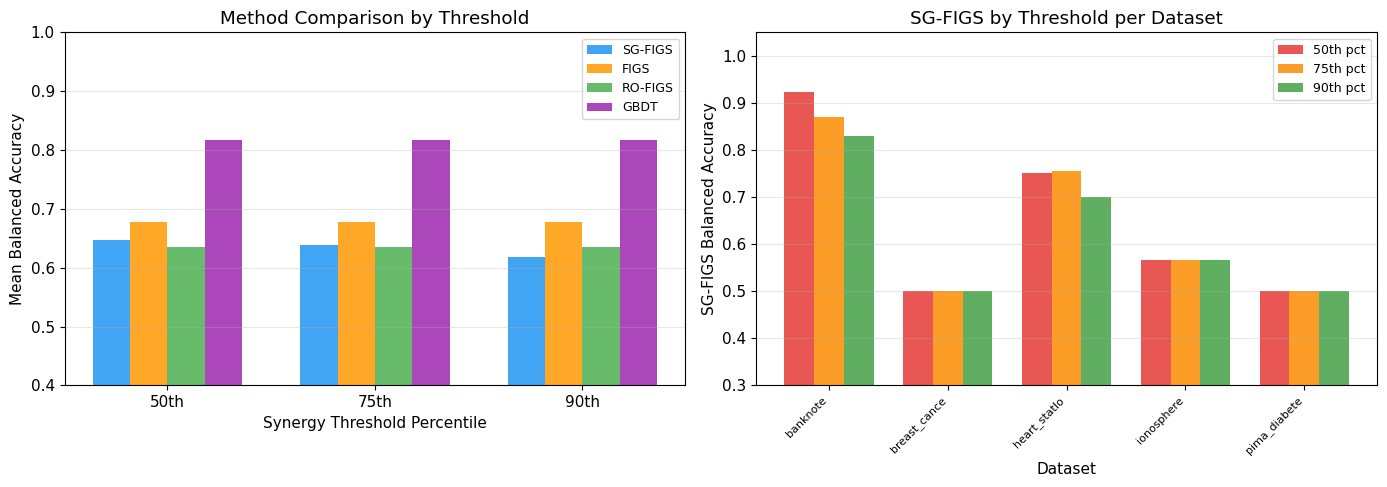

Saved: threshold_sensitivity.png


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Method comparison by threshold percentile ---
ax = axes[0]
methods = ["mean_sg_figs_acc", "mean_figs_acc", "mean_rofigs_acc", "mean_gbdt_acc"]
method_labels = ["SG-FIGS", "FIGS", "RO-FIGS", "GBDT"]
colors = ["#2196F3", "#FF9800", "#4CAF50", "#9C27B0"]

x = np.arange(len(THRESHOLD_PERCENTILES))
width = 0.18

for i, (method, label, color) in enumerate(zip(methods, method_labels, colors)):
    means = []
    for p in THRESHOLD_PERCENTILES:
        vals = []
        for ds_name in dataset_names:
            tr = per_dataset_analysis[ds_name]["threshold_results"]
            if str(p) in tr:
                vals.append(tr[str(p)][method])
        means.append(float(np.mean(vals)) if vals else 0.5)
    ax.bar(x + i * width, means, width, label=label, color=color, alpha=0.85)

ax.set_xlabel("Synergy Threshold Percentile")
ax.set_ylabel("Mean Balanced Accuracy")
ax.set_title("Method Comparison by Threshold")
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels([f"{p}th" for p in THRESHOLD_PERCENTILES])
ax.legend(fontsize=9)
ax.set_ylim(0.4, 1.0)
ax.grid(axis="y", alpha=0.3)

# --- Plot 2: Per-dataset SG-FIGS performance by threshold ---
ax = axes[1]
short_names = [d[:12] for d in dataset_names]
x = np.arange(len(dataset_names))
width = 0.25
pct_colors = ["#E53935", "#FB8C00", "#43A047"]

for i, (pct, color) in enumerate(zip(THRESHOLD_PERCENTILES, pct_colors)):
    accs = []
    for ds_name in dataset_names:
        tr = per_dataset_analysis[ds_name]["threshold_results"]
        if str(pct) in tr:
            accs.append(tr[str(pct)]["mean_sg_figs_acc"])
        else:
            accs.append(0.5)
    ax.bar(x + i * width, accs, width, label=f"{pct}th pct", color=color, alpha=0.85)

ax.set_xlabel("Dataset")
ax.set_ylabel("SG-FIGS Balanced Accuracy")
ax.set_title("SG-FIGS by Threshold per Dataset")
ax.set_xticks(x + width)
ax.set_xticklabels(short_names, rotation=45, ha="right", fontsize=8)
ax.legend(fontsize=9)
ax.set_ylim(0.3, 1.05)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("threshold_sensitivity.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: threshold_sensitivity.png")